# Food Demand Project: Malawi
### Team Henry Theil: Emily, Yuki, Hannah, Noah, Jerry, Anuj


### Motivation 
This project is about understanding people's choices about what food to eat (and how much). In examining food demand, we focus on the relationship between diet, budget, and prices. The overall goal of this project is to give a clear characterization of the relationship of food demand for the Malawian population. Later, we will specifically focus in on the nutrition intake of the Malawian infant population to explore trends of malnutrition. 

In [1]:
!pip install -r requirements.txt
!pip install ConsumerDemands
!pip install eep153_tools
!pip install python-gnupg
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
!pip install ConsumerDemands
!pip install oauth2client

  Using cached CFEDemands-0.4.0.dev0-py2.py3-none-any.whl (39 kB)
  Attempting uninstall: CFEDemands
    Found existing installation: CFEDemands 0.4.1
    Uninstalling CFEDemands-0.4.1:
      Successfully uninstalled CFEDemands-0.4.1
  Using cached CFEDemands-0.4.1-py2.py3-none-any.whl (39 kB)
  Attempting uninstall: CFEDemands
    Found existing installation: CFEDemands 0.4.0.dev0
    Uninstalling CFEDemands-0.4.0.dev0:
      Successfully uninstalled CFEDemands-0.4.0.dev0


# [A] Choice of a Population, with supporting expenditure data

## Data



We will be using the Government of Malawi's _Malawian Food Composition Table 2019_: https://drive.google.com/file/d/1rsTT9EK17yq804T1g3ZfF8MPs5356xpv/view?usp=sharing

And the following Malawian Food Expenditure/Consumption Datasets:

(1) https://docs.google.com/spreadsheets/d/1-rP6IC2wm91nH94xApeLCXS7dslqlsTns9si57Hs1c0/edit?usp=sharing

(2)https://docs.google.com/spreadsheets/d/1c2rXKtnVawQ802xAh4qm5HDK9MiFTFlGZJjcgTooRVo/edit?usp=sharing

(3) https://docs.google.com/spreadsheets/d/1Uy4h4cB3_O6Ls3Pvk920ScTA1jaKdVb4TAkZ51n-8DA/edit#gid=106051197


### Structure of the Spreadsheets



These spreadsheets consist of three worksheets, labeled &ldquo;Expenditures&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Consumption&rdquo;, and &ldquo;FCT&rdquo; respectively.

Each worksheet has the initial three columns labeled &ldquo;j&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;j&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (j,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet should
have one column for each category of expenditures (e.g., &ldquo;Rice&rdquo;, &ldquo;Goat
meat&rdquo;, &ldquo;Millet&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in the ICRISAT data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 



In [2]:
Malawi_Data = '1-rP6IC2wm91nH94xApeLCXS7dslqlsTns9si57Hs1c0'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [3]:
import pandas as pd
import numpy as np
import sys
from eep153_tools.sheets import read_sheets

x = read_sheets(Malawi_Data, sheet='Expenditures')
x.columns.name = 'i'
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
z = read_sheets(Malawi_Data, sheet='HH Characteristics')
z.columns.name = 'k'

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1

# x may have duplicate columns
x = x.groupby('i',axis=1).sum()
x = x.set_index(['j', 't', 'm'])

# convert df to integers, then fill with NaN
x = x.replace('NaN', 0)
x = x.fillna(0)
x = x.astype(int)
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
def log_transform(df, cols):
    copy = df.copy()
    for column in cols:
        copy[column] = np.log(copy[column])
    return copy

y = log_transform(x, x.columns)

z.set_index(['j','t','m'],inplace=True)

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


This gives a dataframe of household characteristics $z$ with a simple structure.



In [4]:
z.head()

,,k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
j,t,m,,,,,,,,,,,,,,
10101002025,2004,1,1,0,1,1,0,1,0,1,1,0,0,0,1,0
10101002051,2004,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10101002072,2004,1,1,1,0,1,0,1,0,1,0,0,0,1,0,0
10101002079,2004,1,0,1,0,0,0,1,0,2,1,0,0,0,1,0
10101002095,2004,1,0,0,2,0,1,0,0,0,2,0,0,1,0,0


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [5]:
y.head()

,,i,Apple,Avocado,Banana,"Bean, brown","Bean, white",Beef,Biscuits,Bottled water,Bottled/ canned beer,Bread,...,Tomato,Tomato sauce (bottle),Traditional beer (masase),Wheat flour,White sweet potato,"Wild fruit (masau, mlambe, etc.)",Wine or commercial liquor,"Yeast, baking powder, bicarbonate of soda",Yoghurt,nan
j,t,m,,,,,,,,,,,,,,,,,,,,,
10101002025,2004,1,NaN,2.302585,NaN,NaN,NaN,5.075174,NaN,NaN,NaN,NaN,...,1.609438,NaN,NaN,NaN,NaN,NaN,NaN,1.386294,NaN,NaN
10101002051,2004,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.609438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10101002072,2004,1,NaN,1.609438,1.609438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.098612,NaN,NaN
10101002079,2004,1,NaN,2.772589,4.094345,NaN,NaN,4.094345,NaN,NaN,NaN,NaN,...,2.302585,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,NaN,NaN
10101002095,2004,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.098612,NaN,NaN


# [A] Estimate Demand System
Estimate a system of demands for different kinds of food. Characterize how consumption varies with household need. 


With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [6]:
import cfe

result = cfe.Result(y=y,z=z)

Missing dependencies for OracleDemands.


This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [7]:
result

<xarray.Result>
Dimensions:           (k: 14, j: 23551, t: 2, m: 1, i: 49)
Coordinates:
  * j                 (j) int64 10101002025 10101002051 ... 315556140434
  * t                 (t) int64 2004 2010
  * m                 (m) int64 1
  * i                 (i) <U41 'Avocado' ... 'Yeast, baking powder, bicarbona...
  * k                 (k) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
Data variables: (12/20)
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 1.0 nan 0.0 nan ... nan 0.0 nan 0.0
    loglambdas        object None
    ...                ...
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, t, m) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 1.0 nan 0.0 nan ... nan 0.0 nan 0.0
Attributes:
    firstround:            2004
    min_proportion_items:  0.125
    min_xproducts:         30
    all_tm:                True
    common_alpha:          True
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    iterate:               False
    verbose:               False

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [8]:
result.get_reduced_form()

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,retur

After running this we can examine the estimated coefficients $\delta$:



In [9]:
result.delta.to_dataframe().unstack('k')

delta                      \
k                                             M 0-3     M 4-8    M 9-13   
i                                                                         
Avocado                                   -0.027469  0.036233 -0.003036   
Banana                                    -0.094776 -0.079738  0.054585   
Bean, brown                                0.033756  0.058986  0.062206   
Bean, white                                0.088998  0.050373  0.097664   
Beef                                      -0.098905  0.033595  0.060964   
Biscuits                                  -0.224607 -0.173919  0.092814   
Bread                                     -0.065294 -0.004541  0.059943   
Buns, scones                               0.045246  0.120182  0.113218   
Cabbage                                    0.014356  0.015227  0.079775   
Cassava tubers                             0.027358  0.048204  0.101075   
Chicken                                   -0.109181  0.007102  0.016048   
Chinese cabbage                            0.103933 -0.009215  0.075137   
Chips (vendor)                            -0.054027 -0.069796  0.035470   
Citrus, naartje, orange, etc.              0.005910 -0.110700  0.039455   
Cooking oil                               -0.099341 -0.079330  0.009946   
Dried fish                                -0.008991  0.006457  0.023662   
Eggs                                      -0.056172 -0.002189  0.055644   
Freezes (flavoured ice)                    0.126634  0.058527 -0.054907   
Fresh fish                                -0.121088 -0.049693 -0.031192   
Fresh milk                                -0.073576 -0.040439  0.057022   
Goat                                      -0.007920 -0.012172  0.109584   
Green maize                               -0.058496  0.010045  0.122148   
Groundnut                                 -0.028979 -0.001292  0.052138   
Groundnut flour                           -0.048324 -0.047073 -0.018861   
Irish potato                              -0.091835 -0.061779  0.038687   
Maize - boiled or roasted                 -0.041780  0.024351  0.097697   
Maize ufa mgaiwa (normal flour)            0.064310  0.112515  0.041167   
Maize ufa refined (fine flour)             0.018110  0.063524  0.142145   
Mandazi, doughnut (vendor)                 0.046214  0.009386  0.062543   
Meat (vendor)                             -0.004185  0.053168 -0.023871   
Meat eaten at restaurant                  -0.280654 -0.132582  0.000111   
Nkwani                                     0.031160  0.033066  0.047762   
Okra / Therere                             0.014872 -0.055624  0.051188   
Onion                                     -0.091255 -0.071492  0.024967   
Orange sweet potato                        0.161137  0.019499  0.062452   
Pork                                      -0.011009 -0.006449  0.131056   
Powdered milk                             -0.256034 -0.050838 -0.001133   
Rice                                      -0.039716 -0.001724  0.017940   
Salt                                       0.003369  0.010418  0.082138   
Samosa (vendor)                           -0.247947  0.056758 -0.128120   
Soft drinks (coca cola, fanta)            -0.100256 -0.027790 -0.008544   
Sugar                                      0.064521  0.044586  0.073426   
Sugar cane                                 0.081139  0.010243  0.090556   
Sweets, candy, chocolates                 -0.290199 -0.086628 -0.118559   
Tanaposi rape                              0.042259  0.039258  0.050717   
Tea                                       -0.084797 -0.006682  0.072521   
Tomato                                    -0.100691 -0.075390  0.004835   
White sweet potato                         0.046810  0.057825  0.181314   
Yeast, baking powder, bicarbonate of soda -0.110725 -0.072785  0.022043   

                                                                         \
k                                           M 14-18   M 19-30   M 31-5

Also the good-time constants $a_{it}$ (this captures the effects of prices)



In [10]:
result.a.to_dataframe().unstack('i')

a                                                        \
i        Avocado    Banana Bean, brown Bean, white      Beef  Biscuits   
t    m                                                                   
2004 1  2.732589  2.553386    3.563498    3.480738  4.906085  2.736930   
2010 1  3.709544  3.873656    4.573519    4.511708  5.846323  3.824394   

                                                        ...                  \
i          Bread Buns, scones   Cabbage Cassava tubers  ... Samosa (vendor)   
t    m                                                  ...                   
2004 1  4.330692     3.272087  2.821576       2.735024  ...        2.692764   
2010 1  5.089198     4.234627  3.772250       3.782887  ...        3.680945   

                                                            \
i      Soft drinks (coca cola, fanta)     Sugar Sugar cane   
t    m                                                       
2004 1                       4.026075  3.647259   2.475238   
2010 1                       4.758748  4.549718   3.376966   

                                                                    \
i      Sweets, candy, chocolates Tanaposi rape       Tea    Tomato   
t    m                                                               
2004 1                  1.879936      2.486638  2.237929  3.439653   
2010 1                  3.224241      3.538246  2.994732  4.361938   

                                                                     
i      White sweet potato Yeast, baking powder, bicarbonate of soda  
t    m                                                               
2004 1           2.985221                                  1.016818  
2010 1           4.048783                                  2.198148  

[2 rows x 49 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [11]:
result.get_beta(as_df=True)

i
Avocado                                      0.383249
Banana                                       0.598940
Bean, brown                                  0.192255
Bean, white                                  0.232248
Beef                                         0.365007
Biscuits                                     0.816535
Bread                                        0.360046
Buns, scones                                 0.303703
Cabbage                                      0.259849
Cassava tubers                               0.286150
Chicken                                      0.276638
Chinese cabbage                              0.313419
Chips (vendor)                               0.352606
Citrus, naartje, orange, etc.                0.648388
Cooking oil                                  0.591433
Dried fish                                   0.369809
Eggs                                         0.357952
Freezes (flavoured ice)                      0.561462
Fresh fish                

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



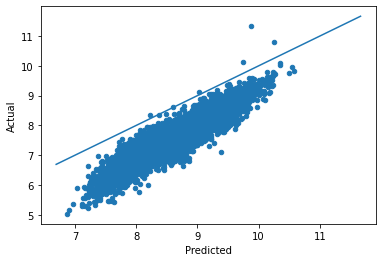

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### Did something below that we should describe to better fit the model 

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,return_e=True)
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:447: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=rhs.append(znil.join(timednil))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:451: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  myb,mye=ols(X,lhs.append(ynil),return_se=False,return_v=False,retur

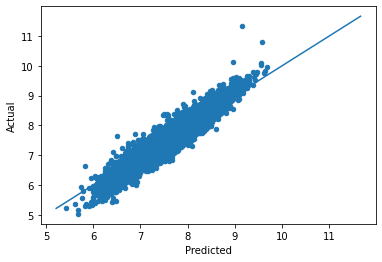

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

zeros_r = cfe.Result(y=(0.+(np.exp(result.y)>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### Saving Result



You can save the estimated result, using something like



In [ ]:
result.to_dataset('Malawi.ds')

# [B] Nutritional content of different foods 

Nutrient values are per 100g of food

In [157]:
nutrient_table_ = read_sheets('1SvJvCWpSgkhDJ7PK9hkgygiWt0yFvqk5xH2l58JeT70', sheet='Sheet1')

Key available for students@eep153.iam.gserviceaccount.com.


In [158]:
nutrient_table = nutrient_table_.T.copy()
new_cols = nutrient_table.iloc[3,0:]
nutrient_table.columns = new_cols
nutrient_table = nutrient_table.replace('', 0)
nutrient_table.fillna(0, inplace=True)
nutrient_table = nutrient_table[4:]
nutrient_table = nutrient_table.drop(nutrient_table.columns[0], axis=1)
nutrient_table = nutrient_table.drop("Energy2", axis=0)
nutrient_table = nutrient_table.astype(float)
nutrient_table

Food Item Name,"African cake, (Chikondamoyo/Chigumu cha nthochi ndi dzira)","Banana fritters, (Zitumbuwa)",Bread,"Bread, wheat, white, commercial,(Buledi woyera)","Bread, wheat, white, homemade,(Buledi woyera)","Bean and groundnut stew, (Ndawva)","Bean soup, (Supu wa nyemba)","Bean stew, (Nyemba zouma zokazingira)","Beef mince, fried, (Nyama ya ng'ombe yogaya yokazinga)","Beef stew, (Nyama ya ng'ombe yokazingira)",...,Squash (Sobo drink concentrate),"Termites, other insect",Tinned meat or fish,Tinned vegetables,Tomato sauce (bottle),Traditional beer (masase),Wheat flour,"Wild fruit (masau, mlambe, etc.)",Wine or commercial liquor,Yoghurt (Baby Food)
Mois,49.000,54.800,11.200,35.600,37.200,89.100,88.700,88.20,67.300,73.600,...,89.00,2.90,13.000,95.000,83.500,0.0,67.200,79.50,0.0,81.900
Energy,215.000,189.000,362.000,256.000,270.000,54.000,44.000,49.00,159.000,94.000,...,47.00,627.00,364.000,19.000,101.000,0.0,149.000,80.00,0.0,71.000
N,0.910,0.510,1.720,1.360,1.650,0.440,0.460,0.46,2.540,2.700,...,0.84,6.56,10.760,0.130,0.240,0.0,0.830,0.13,0.0,0.060
Protein,5.700,3.200,10.700,8.500,10.400,2.700,2.900,2.90,15.900,16.900,...,5.20,41.00,67.200,0.800,1.500,0.0,5.200,0.80,0.0,0.400
Fat,3.000,2.500,6.200,1.500,4.600,2.300,0.100,0.80,9.300,1.300,...,1.10,48.20,10.100,0.100,6.600,0.0,4.900,0.20,0.0,0.100
SAFA,0.000,0.120,1.710,0.000,0.000,0.000,0.000,0.07,0.840,0.000,...,0.00,0.00,0.000,0.000,3.220,0.0,0.590,0.00,0.0,0.000
MUFA,0.000,0.230,0.930,0.000,0.000,0.000,0.000,0.13,1.590,0.000,...,0.00,0.00,0.000,0.000,1.750,0.0,0.320,0.00,0.0,0.000
PUFA,0.000,0.790,0.520,0.000,0.000,0.000,0.000,0.45,5.350,0.000,...,0.00,0.00,0.000,0.000,0.990,0.0,0.180,0.00,0.0,0.000
Chol,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.0,0.000,0.00,0.0,0.000
"Carbohydrate, by difference",41.400,38.500,65.900,52.100,46.900,5.500,7.800,7.60,2.900,3.800,...,4.10,7.30,1.000,3.600,8.900,0.0,21.100,18.90,0.0,0.000


# [B] Nutritional adequacy of diet
Calculating what proportion of households consume enough so that members will exceed dietary recommendations

In [159]:
dietary_minimums = pd.read_csv('../Project2/diet_minimums.csv').set_index('Nutrition').iloc[:,2:]
dietary_minimums = dietary_minimums.drop("Vitamin K (phylloquinone)", axis=0)
dietary_minimums

,C 1-3,F 4-8,M 4-8,F 9-13,M 9-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
Nutrition,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


### Grab and format consumption table

In [161]:
# grab consumption sheets
malawi_consumption_purch = read_sheets('1c2rXKtnVawQ802xAh4qm5HDK9MiFTFlGZJjcgTooRVo', sheet='malawi_consumption')
malawi_consumption_own_prod = read_sheets('1Uy4h4cB3_O6Ls3Pvk920ScTA1jaKdVb4TAkZ51n-8DA', sheet='malawi_consumption_ownproduction')

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [162]:
malawi_consumption = malawi_consumption_purch.append(malawi_consumption_own_prod)e
malawi_consumption.fillna(0, inplace=True)

/tmp/ipykernel_301/3766712738.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  malawi_consumption = malawi_consumption_purch.append(malawi_consumption_own_prod)


In [163]:
malawi_consumption

,t,j,u,Apple,Avocado,Banana,"Bean, brown","Bean, white",Beef,Biscuits,...,Tomato,Tomato sauce (bottle),Traditional beer (masase),Wheat flour,White sweet potato,"Wild fruit (masau, mlambe, etc.)",Wine or commercial liquor,"Yeast, baking powder, bicarbonate of soda",Yoghurt,nan
0,2004,10101002025,Gram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,10101002025,Kg,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,10101002025,Millilitre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2004,10101002025,Piece,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004,10101002051,Gram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21165,2004,31202086305,Piece,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21166,2004,31202086331,Piece,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21167,2004,31202086344,Piece,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21168,2004,31202086364,Piece,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
piece_to_grams = {
    "Avocado": 50,
    "Onion": 170,
    "Cabbage": 908,
    "Chinese cabbage": 908,
    "Citrus, naartje, orange, etc.": 154,
    "Eggs": 50,
    "Eggs - boiled (vendor)": 50,
    "Mandazi, doughnut (vendor)": 28,
    "Other poultry-guinea fowl, doves": 90,
    "Meat (vendor)": 90,
    "Sugar cane": 10,
    "Tomato": 150,
    "Pumpkin": 250,
    "Plantain, cooking banana": 240,
    "Guava": 55,
    "Dried fish": 30,
    "Chicken": 90,
    "Chicken (vendor)": 90,
    "Cassava tubers": 200,
    "Cassava - boiled (vendor)": 200,
    "Buns, scones": 120,
    "Irish potato": 173,
    "Mango": 150,
    "Fresh fish": 200,
    "Papaya": 100,
    "Samosa (vendor)": 100,
    "Sweets, candy, chocolates": 40,
    "Orange sweet potato": 100,
    "Okra / Therere": 50,
}    

### Convert units to Hectograms

In [165]:
# Create conversion dictionary
units = {'Gram': 0.01, 
 'Kg': 10,
 'Millilitre': 0.01,
 'Litre': 1,
 '50kg bag': 500, 'Piece': 1, 'Bunch': 3, 'Satchet/Tube/Packet': 1,
}

In [166]:
malawi_consumption.insert(loc=2, column='m', value=1)
malawi_consumption.set_index(['t', 'j', 'm'], inplace=True)
hect_consumption = malawi_consumption.set_index('u', append=True)
hect_consumption = hect_consumption.sort_index()
hect_consumption

Apple  Avocado  Banana  Bean, brown  \
t    j           m u                                                 
2004 10101002025 1 Gram          0.0      0.0     0.0          0.0   
                   Kg            0.0      0.0     0.0          0.0   
                   Kg            0.0      0.0     0.0          0.0   
                   Litre         0.0      0.0     0.0          0.0   
                   Millilitre    0.0      0.0     0.0          0.0   
...                              ...      ...     ...          ...   
     31202086364 1 Piece         0.0      0.0     0.0          0.0   
                   Piece         0.0      0.0     0.0          0.0   
     31202086374 1 Kg            0.0      0.0     0.0          0.0   
                   Piece         0.0      0.0     0.0          0.0   
                   Piece         0.0      0.0     0.0          0.0   

                               Bean, white  Beef  Biscuits  Bottled water  \
t    j           m u                                                        
2004 10101002025 1 Gram                0.0   0.0       0.0            0.0   
                   Kg                  0.0   2.0       0.0            0.0   
                   Kg                  2.0   0.0       0.0            0.0   
                   Litre               0.0   0.0       0.0            0.0   
                   Millilitre          0.0   0.0       0.0            0.0   
...                                    ...   ...       ...            ...   
     31202086364 1 Piece               0.0   0.0       0.0            0.0   
                   Piece               0.0   0.0       0.0            0.0   
     31202086374 1 Kg                  0.0   0.0       0.0            0.0   
                   Piece               0.0   0.0       0.0            0.0   
                   Piece               0.0   0.0       0.0            0.0   

                               Bottled/ canned beer  Bread  ...  Tomato  \
t    j           m u                                        ...           
2004 10101002025 1 Gram                         0.0    0.0  ...     0.0   
                   Kg                           0.0    0.0  ...     0.0   
                   Kg                           0.0    0.0  ...     0.0   
                   Litre                        0.0    0.0  ...     0.0   
                   Millilitre                   0.0    0.0  ...     0.0   
...                                             ...    ...  ...     ...   
     31202086364 1 Piece                        0.0    0.0  ...    15.0   
                   Piece                        0.0    0.0  ...     0.0   
     31202086374 1 Kg                           0.0    0.0  ...     0.0   
                   Piece                        0.0    0.0  ...     7.0   
                   Piece                        0.0    0.0  ...     0.0   

                               Tomato sauce (bottle)  \
t    j           m u                                   
2004 10101002025 1 Gram                          0.0   
                   Kg                            0.0   
                   Kg                            0.0   
                   Litre                         0.0   
                   Millilitre                    0.0   
...                                              ...   
     31202086364 1 Piece                         0.0   
                   Piece                         0.0   
     31202086374 1 Kg                            0.0   
                   Piece                         0.0   
                   Piece                         0.0   

                               Traditional beer (masase)  Wheat flour  \
t    j           m u                                                    
2004 10101002025 1 Gram                              0.0          0.0   
                   Kg                                0.0          0.0   
                   Kg                                0.0          0.0   
                   Litre                        

In [167]:
for index, row in hect_consumption.iterrows():
    unit_factor = units[index[3]]
    row *= unit_factor

# for i in hect_consumption.index:
#     unit_factor = units[i[3]]
#     hect_consumption.loc[i] *= unit_factor
    
hect_consumption = hect_consumption.reset_index()
hect_consumption = hect_consumption.set_index(['t', 'j', 'm'])
hect_consumption.drop("u", axis=1)
hect_consumption
#     row 
#     hect_consumption.loc[i] *= unit_factor

u  Apple  Avocado  Banana  Bean, brown  \
t    j           m                                                    
2004 10101002025 1        Gram    0.0      0.0     0.0          0.0   
                 1          Kg    0.0      0.0     0.0          0.0   
                 1          Kg    0.0      0.0     0.0          0.0   
                 1       Litre    0.0      0.0     0.0          0.0   
                 1  Millilitre    0.0      0.0     0.0          0.0   
...                        ...    ...      ...     ...          ...   
     31202086364 1       Piece    0.0      0.0     0.0          0.0   
                 1       Piece    0.0      0.0     0.0          0.0   
     31202086374 1          Kg    0.0      0.0     0.0          0.0   
                 1       Piece    0.0      0.0     0.0          0.0   
                 1       Piece    0.0      0.0     0.0          0.0   

                    Bean, white  Beef  Biscuits  Bottled water  \
t    j           m                                               
2004 10101002025 1          0.0   0.0       0.0            0.0   
                 1          0.0  20.0       0.0            0.0   
                 1         20.0   0.0       0.0            0.0   
                 1          0.0   0.0       0.0            0.0   
                 1          0.0   0.0       0.0            0.0   
...                         ...   ...       ...            ...   
     31202086364 1          0.0   0.0       0.0            0.0   
                 1          0.0   0.0       0.0            0.0   
     31202086374 1          0.0   0.0       0.0            0.0   
                 1          0.0   0.0       0.0            0.0   
                 1          0.0   0.0       0.0            0.0   

                    Bottled/ canned beer  ...  Tomato  Tomato sauce (bottle)  \
t    j           m                        ...                                  
2004 10101002025 1                   0.0  ...     0.0                    0.0   
                 1                   0.0  ...     0.0                    0.0   
                 1                   0.0  ...     0.0                    0.0   
                 1                   0.0  ...     0.0                    0.0   
                 1                   0.0  ...     0.0                    0.0   
...                                  ...  ...     ...                    ...   
     31202086364 1                   0.0  ...    15.0                    0.0   
                 1                   0.0  ...     0.0                    0.0   
     31202086374 1                   0.0  ...     0.0                    0.0   
                 1                   0.0  ...     7.0                    0.0   
                 1                   0.0  ...     0.0                    0.0   

                    Traditional beer (masase)  Wheat flour  \
t    j           m                                           
2004 10101002025 1                        0.0          0.0   
                 1                        0.0          0.0   
                 1                        0.0          0.0   
                 1                        0.0          0.0   
                 1                        0.0          0.0   
...                                       ...          ...   
     31202086364 1                        0.0          0.0   
                 1                        0.0          0.0   
     31202086374 1                        0.0          0.0   
                 1                        0.0          0.0   
                 1                        0.0          0.0   

                    White sweet potato  Wild fruit (masau, mlambe, etc.)  \
t    j           m                                                         
2004 10101002025 1                 0.0                               0.0   
                 1                 0.0                               0.0   
                 1                 0.0                               0.0   
                 1

### Aggregate household consumption and convert into nutrients

In [168]:
def total_household_consumption(h_idx):
    df = hect_consumption.loc[h_idx]
    df = df.groupby(by=df.index, as_index=True).sum()
    return df
total_household_consumption(hect_consumption.index[0])

,Apple,Avocado,Banana,"Bean, brown","Bean, white",Beef,Biscuits,Bottled water,Bottled/ canned beer,Bread,...,Tomato,Tomato sauce (bottle),Traditional beer (masase),Wheat flour,White sweet potato,"Wild fruit (masau, mlambe, etc.)",Wine or commercial liquor,"Yeast, baking powder, bicarbonate of soda",Yoghurt,nan
"(2004, 10101002025, 1)",0.0,2.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
def food_to_nutrients(food_name):
    if food_name in nutrient_table.columns:
        return nutrient_table[food_name]
    else:
#         temporary placeholder to skip errors
        return nutrient_table["African cake, (Chikondamoyo/Chigumu cha nthochi ndi dzira)"]
def household_total_nutrient_intake(idx, nutritions):
    household_consumption = total_household_consumption(idx)
    total = 0
    for col in household_consumption.columns:
        amount = household_consumption[col][0]
        nutri = amount * food_to_nutrients(col)
#         print(nutri)
        total += nutri
    total = total[total.index.isin(nutritions)]
    
    # convert weekly data values to daily values
    total = total / 7
    total = total.rename('Total Nutritional Intake For ' + str(idx))
    return pd.DataFrame(total)

In [193]:
household_total_nutrient_intake(hect_consumption.index[0], dietary_minimums.index)

,"Total Nutritional Intake For (2004, 10101002025, 1)"
Energy,10694.428571
Protein,267.722857
"Carbohydrate, by difference",2072.271429
"Fiber, total dietary",179.514286
"Calcium, Ca",901.428571
"Iron, Fe",79.964286
"Magnesium, Mg",1277.885714
"Phosphorus, P",2906.285714
"Potassium, K",7788.285714
"Zinc, Zn",86.033571


In [171]:
household_characteristics = read_sheets('1-rP6IC2wm91nH94xApeLCXS7dslqlsTns9si57Hs1c0', sheet='HH Characteristics')
household_characteristics['m'] = 1
household_characteristics.set_index(['t','j','m'],inplace=True)
household_characteristics

Key available for students@eep153.iam.gserviceaccount.com.


M 0-3  M 4-8  M 9-13  M 14-18  M 19-30  M 31-50  M 51+  \
t    j            m                                                           
2004 10101002025  1      1      0       1        1        0        1      0   
     10101002051  1      0      0       0        0        1        0      0   
     10101002072  1      1      1       0        1        0        1      0   
     10101002079  1      0      1       0        0        0        1      0   
     10101002095  1      0      0       2        0        1        0      0   
...                    ...    ...     ...      ...      ...      ...    ...   
2010 315556140342 1      1      0       0        0        1        0      0   
     315556140365 1      0      0       0        0        0        1      0   
     315556140388 1      0      0       0        0        1        0      0   
     315556140411 1      1      0       0        0        2        0      0   
     315556140434 1      0      0       0        1        0        1      0   

                     F 0-3  F 4-8  F 9-13  F 14-18  F 19-30  F 31-50  F 51+  
t    j            m                                                          
2004 10101002025  1      1      1       0        0        0        1      0  
     10101002051  1      1      0       0        1        0        0      0  
     10101002072  1      1      0       0        0        1        0      0  
     10101002079  1      2      1       0        0        0        1      0  
     10101002095  1      0      2       0        0        1        0      0  
...                    ...    ...     ...      ...      ...      ...    ...  
2010 315556140342 1      0      0       0        0        1        0      0  
     315556140365 1      0      0       0        0        0        1      0  
     315556140388 1      0      0       0        1        0        0      0  
     315556140411 1      1      0       0        0        1        0      0  
     315556140434 1      0      0       2        0        2        1      0  

[23551 rows x 14 columns]

In [172]:
dietary_minimums

,C 1-3,F 4-8,M 4-8,F 9-13,M 9-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
Nutrition,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


In [173]:
def household_total_dietary_requirement(household):
    # household characteristics
    member_list = household_characteristics.loc[household]
    
    # loop through every age group and sum up their dri requirements
    total = 0
    for group in member_list.index:
        if group == 'M 0-3' or group == 'F 0-3':
            total += dietary_minimums['C 1-3'] * member_list[group]
        else:
            total += dietary_minimums[group] * member_list[group]
    total = total.rename('Total Dietary Requirement for Household: ' + str(household))
    return pd.DataFrame(total)

In [174]:
household_total_dietary_requirement(hect_consumption.index[0])

,"Total Dietary Requirement for Household: (2004, 10101002025, 1)"
Nutrition,
Energy,11200.0
Protein,233.0
"Fiber, total dietary",156.8
"Folate, DFE",2000.0
"Calcium, Ca",7000.0
"Carbohydrate, by difference",910.0
"Iron, Fe",69.0
"Magnesium, Mg",1680.0
Niacin,78.0


In [205]:
a = household_total_nutrient_intake(hect_consumption.index[20022], dietary_minimums.index)
b = household_total_dietary_requirement(hect_consumption.index[20022])

df = pd.concat([b, a], axis=1)
df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
df

,"Total Dietary Requirement for Household: (2004, 20603111187, 1)","Total Nutritional Intake For (2004, 20603111187, 1)",Excess
Energy,4400.0,11135.428571,6735.428571
Protein,102.0,242.114286,140.114286
"Fiber, total dietary",61.6,131.285714,69.685714
"Folate, DFE",800.0,787.714286,-12.285714
"Calcium, Ca",2000.0,11171.142857,9171.142857
"Carbohydrate, by difference",260.0,1660.057143,1400.057143
"Iron, Fe",26.0,736.085714,710.085714
"Magnesium, Mg",710.0,4566.857143,3856.857143
Niacin,30.0,55.571429,25.571429
"Phosphorus, P",1400.0,3118.285714,1718.285714


In [176]:
def check_dri_req(household):
    a = household_total_nutrient_intake(household, dietary_minimums.index)
    b = household_total_dietary_requirement(household)
    df = pd.concat([b, a], axis=1)
    df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
    return (df['Excess'].values > 0).all()

In [177]:
check_dri_req(hect_consumption.index[199])

False

In [178]:
num_households_total = len(set(hect_consumption.index))
num_households_total

11258

In [179]:
num_satisfying = 0

# add indices of households that meet requirements to empty list
for i in set(hect_consumption.index):
    if check_dri_req(i):
        num_satisfying += 1


In [180]:
num_satisfying

323

In [182]:
total_num_h = len(hect_consumption.index)
proportion = num_satisfying / total_num_h
proportion

0.0056520902234587994

# [C] Counterfactual Experiments
If everyone's total food expenditures doubled (holding prices fixed) how would this afect nutrition in the population? What if relative food prices changed?

In [186]:
def household_total_nutrient_intake_times_x(idx, nutritions, x):
    household_consumption = total_household_consumption(idx)
    total = 0
    for col in household_consumption.columns:
        amount = household_consumption[col][0]
        nutri = amount * food_to_nutrients(col)
#         print(nutri)
        total += nutri
    total = total[total.index.isin(nutritions)]
    
    # convert weekly data values to daily values
    total = total / 7
    total = total * x
    total = total.rename('Total Nutritional Data for Household: ' + str(idx))
    return pd.DataFrame(total)

def check_nutritional_adequacy_cf(household, x):
    a = household_total_nutrient_intake_times_x(household, dietary_minimums.index, x)
    b = household_total_dietary_requirement(household)
    df = pd.concat([b, a], axis=1)
    df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
    return (df['Excess'].values > 0).all()

In [188]:
num_satisfying_counterfactual = 0

# add indices of households that meet requirements to empty list
for i in set(hect_consumption.index):
    if check_nutritional_adequacy_cf(i, 2):
        num_satisfying_counterfactual += 1

In [194]:
num_satisfying_counterfactual

1364

In [195]:
total_num_h = len(hect_consumption.index)
proportion = num_satisfying_counterfactual / total_num_h
proportion

0.02386826955045759

In [198]:
results = {}
def counterfactual(x):
    result = 0
    for i in set(hect_consumption.index):
        if check_nutritional_adequacy_cf(i, x):
            result += 1
    total_num_h = len(hect_consumption.index)
    proportion = result / total_num_h
    print(proportion)
    results[x] = proportion

In [199]:
counterfactual(3)

0.04001959857910301


In [200]:
counterfactual(4)

0.05249619402593312


In [ ]:
counterfactual(2.5)